# Tabla de contenido
* [Descripción del proyecto](#descripcion)
    * [Análisis de datos](#analisis)
        * [TripleTen Data Science Bootcamp](#tripleten)
        * [Servicios de Interconnect](#interconnect)
        * [Descripción de los datos](#descripcion)
    * [Importación de datos](#importacion)
        * [Contratos](#contrato)
        * [Personal](#personal)
        * [Internet](#internet)
        * [Teléfono](#telefono)
* [Merge de los datasets](#merge)
* [Análisis Exploratorio de datos](#eda)
* [Clientes perdidos vs clientes activos](#clientes)
    * [Tipo de contrato](#contrato)
    * [Metodos de pago](#metodos)
    * [Tipos de servicio de internet](#serviciosinternet)
    * [Genero sexual](#genero)
* [Tendencia de Cargos](#cargos)
    * [Cargos Mensuales](#mensuales)
    * [Cargos totales](#totales)
* [One Hot Encoding](#ohe)
* [Segmentación de datos](#segmentacion)
* [Balance de clases](#balance)
* [Estandarizar datos](#estandarizar)
    * [Entrenamiento de los modelos](#entrenamiento)
    * [Regresión Logistica](#regresion)
    * [Arboles de decisión](#arboles)
    * [Random Forest](#random)
    * [XBGClassifier](#xgbc)
    * [LGBMClassifier](#lgbm)
* [Conclusión](#conclusion)

# Descripción del proyecto 
<a dir='descripcion'></a>
## Análisis de datos
<a dir='analisis'></a>
### TripleTen Data Science Bootcamp
<a dir='tripleten'></a>
Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect
<a dir='interconnect'></a>
Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos
<a dir='descripcion'></a>

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

## Importación de librerias y carga de datos
<a id='importacion'></a>

In [129]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [130]:
conda install -c anaconda py-xgboost


Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import time
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import re
from scipy import stats
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
from lightgbm   import LGBMClassifier
from xgboost    import XGBClassifier


In [132]:
try:
    contract = pd.read_csv('contract.csv')
    personal = pd.read_csv('personal.csv')
    internet = pd.read_csv('internet.csv')
    phone = pd.read_csv('phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv') 
    personal = pd.read_csv('/datasets/final_provider/personal.csv') 
    internet = pd.read_csv('/datasets/final_provider/internet.csv') 
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

Se importaron los datos, en este caso se utilizo el try-except para asegurarnos de que los datos se cargan en manera local de la misma manera que en la plataforma de TripleTen

### Contratos
<a id='contrato'></a>

In [133]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Se corrobora que efectivamente se cargaron correctamente los datos.

In [134]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [135]:
 contract.duplicated().sum()

0

In [136]:
contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Este dataframe describe la contracion en terminos generales, es decir la fecha de inicio de su contrato, que servicios contrato, si esta activa su cuenta o no.
* El archivo referente a los contratos tiene 7043 valores
* No tiene NaN
* No tiene filas duplicadas
* La columna referente a la fecha de inicio del contrato se tiene que cambiar de tipo de dato objeto a datetime
* La fecha final va a determinar el target de nuestro proyecto, señalando que es un modelado de churn es decir determinar si esta activo o no, por otro lado esa columna de igual manera que la anterior se tiene que cambiar a un tipo de dato datetime
* La columna type es claramente una columna con caracteristicas, eso la hace candidata a OHE.
* La columna referente al metodo de pago le pasa exactamente lo mismo que la anterior.
* El cargo total de la misma manera se tiene que convertir a flotante

### Personal
<a id='personal'></a>

In [137]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [138]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [139]:
 personal.duplicated().sum()

0

In [140]:
personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Este dataframe tiene los datos demograficos e información de los usuarios
* De la misma manera tiene 7043 datos
* No contiene NaN
* No contiene duplicados
* La columna de genero se pasara a binario, las columnas restantes de la misma manera

In [141]:
dependents = personal[(personal['Partner'] == 'Yes') | (personal['Dependents'] == 'Yes')]

In [142]:
dependents.loc[:,'dependents'] = 'Yes'

C:\Users\omar_\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [143]:
personal['dependents']= dependents['dependents']

In [144]:
personal = personal.drop(['Partner','Dependents'],axis=1)

Se agruparon las columnas referentes a la pareja con la de dependientes, bajo el criterio de que una pareja es dependiente, cabe señalar que dependiente en este caso se toma en cuenta como un posible usuario secundario del servicio.
Para esto se le asigno el valor de 1 cuando cualquiera de estas condiciones se cumple, teniendo asi una columna menos.
Se borraron las columnas tratadas para solamente quedarnos con una, y dejando la columna de adulto mayor, ya que es relevante por posibles ofertas o servicios que tengan.

### Internet
<a dir='internet'></a>

In [145]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [146]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [147]:
internet.duplicated().sum()

0

In [148]:
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Este dataframe se refiere a los servicios de internet, y tiene datos como el tipo de conexión, etc
* Este contiene 5517 datos, es decir no todos los usuarios contrataron internet
* Se tiene que crear una columna que indique 'Yes' si es usuario
* Las demás columnas se tienen que cambiar a binarias
* El tipo de conexión es candidata a OHE

In [149]:
internet['InternetCustomer'] = 'Yes'

In [150]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
 8   InternetCustomer  5517 non-null   object
dtypes: object(9)
memory usage: 388.0+ KB


In [151]:
streaming = internet[(internet['StreamingTV'] == 'Yes') | (internet['StreamingMovies'] == 'Yes')]

In [152]:
streaming.loc[:,'streaming'] = 'Yes'


C:\Users\omar_\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [153]:
streaming['streaming'].value_counts()

Yes    3499
Name: streaming, dtype: int64

In [154]:
internet['streaming'] = streaming['streaming']

In [155]:
internet = internet.drop(['StreamingTV','StreamingMovies'],axis=1)

In [156]:
support = internet[(internet['OnlineSecurity'] == 'Yes') | (internet['OnlineBackup'] == 'Yes') | (internet['DeviceProtection'] == 'Yes') | (internet['TechSupport'] == 'Yes')]

In [157]:
support.loc[:,'support'] = 'Yes'


In [158]:
support['support'].value_counts()

Yes    4250
Name: support, dtype: int64

In [159]:
internet['support'] = support['support']

In [160]:
internet = internet.drop(['InternetService','OnlineSecurity','DeviceProtection','DeviceProtection','TechSupport','OnlineBackup'],axis=1)

Bajo el mismo criterio que en el dataset anterior, se opto por agrupar
* streaming la cual es 1 cuando streamingtv y streamingmovies se cumplen
    * cabe señalar que debido a la falta de información de ese servicio no se encontraron diferencias, y no todos los usuarios de internet cuentan con servicio de streaming
* Los servicios de seguridad, protección, asistencia tecnica o respaldo de información se opto por juntarlos en la columna support
por otro lado se decido hacer de lado la columna referente al tipo de conexión, esto debido a que no se tiene información de la cobertura o de los costos para que pueda hacer diferencia por ende se toma como si cuenta o no con el servicio independientemente si es dsl o fibra optica

In [161]:
internet.columns

Index(['customerID', 'InternetCustomer', 'streaming', 'support'], dtype='object')

### Teléfono
<a dir='telefono'></a>

In [162]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [163]:
phone['PhoneCustomer'] = 'Yes'

In [164]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
 2   PhoneCustomer  6361 non-null   object
dtypes: object(3)
memory usage: 149.2+ KB


In [165]:
phone.duplicated().sum()

0

In [166]:
phone.isna().sum()

customerID       0
MultipleLines    0
PhoneCustomer    0
dtype: int64

Este dataframe tiene la información del usuario si tiene lineas telefonicas o no
* De la misma manera que el dataframe referente a internet, este consta solo de 6361 datos, es decir que no todos los usuarios tienen este servicio
* Se aplico la misma metodologia que el caso anterior, el cual consta de crear otra columna binaria
* En el caso de multilines se cambiara a binario

## Merge de los datasets
<a dir='merge'></a>

El plan propuesto
es acomodar todos los datos a como se sugiere y unirlos en un solo dataframe, con merge
en el caso del internet y phone, se creo una columna con un 1, cuando se unan en el merge van a quedar valores vacios, entonces se tendran que rellenar con 0
Nuestro target se va a derivar de la columna referente a la terminación del contrato
para tratar de emular lo realizado en el proyecto del sprint8

In [167]:
df = personal.merge(contract, left_on=['customerID'], right_on=['customerID'], how='left')
df = df.merge(phone, left_on=['customerID'], right_on=['customerID'], how='left')
df = df.merge(internet, left_on=['customerID'], right_on=['customerID'], how='left')

In [168]:
df.head()

,customerID,gender,SeniorCitizen,dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,PhoneCustomer,InternetCustomer,streaming,support
0,7590-VHVEG,Female,0,Yes,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,NaN,Yes,NaN,Yes
1,5575-GNVDE,Male,0,NaN,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,Yes,Yes,NaN,Yes
2,3668-QPYBK,Male,0,NaN,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,Yes,Yes,NaN,Yes
3,7795-CFOCW,Male,0,NaN,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,NaN,Yes,NaN,Yes
4,9237-HQITU,Female,0,NaN,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Yes,Yes,NaN,NaN


In [169]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'dependents', 'BeginDate',
       'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'MultipleLines', 'PhoneCustomer',
       'InternetCustomer', 'streaming', 'support'],
      dtype='object')

In [170]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')

In [171]:
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d', errors='coerce')

In [172]:
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan).astype(np.float32)

In [173]:
df['InternetCustomer'].fillna('No',inplace=True)

In [174]:
df['PhoneCustomer'].fillna('No',inplace=True)

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   dependents        3763 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   EndDate           1869 non-null   datetime64[ns]
 6   Type              7043 non-null   object        
 7   PaperlessBilling  7043 non-null   object        
 8   PaymentMethod     7043 non-null   object        
 9   MonthlyCharges    7043 non-null   float64       
 10  TotalCharges      7032 non-null   float32       
 11  MultipleLines     6361 non-null   object        
 12  PhoneCustomer     7043 non-null   object        
 13  InternetCustomer  7043 non-null   object        
 14  streaming         3499 n

In [176]:
df['churn'] = df['EndDate'].apply(lambda x: 0 if pd.isna(x) else 1)


In [177]:
df.loc[:,{'EndDate','churn'}]

,churn,EndDate
0,0,NaT
1,0,NaT
2,1,2019-12-01
3,0,NaT
4,1,2019-11-01
...,...,...
7038,0,NaT
7039,0,NaT
7040,0,NaT
7041,1,2019-11-01


primeramente creamos la columna churn, a partir de la fecha de terminación usando los valores vacios como referencia
el motivo de pasar a hacer esto a terminar de rellenar los valores vacios es que se planea rellenarlos en una sola acción 

In [178]:
df.fillna('No',inplace=True)

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   EndDate           7043 non-null   object        
 6   Type              7043 non-null   object        
 7   PaperlessBilling  7043 non-null   object        
 8   PaymentMethod     7043 non-null   object        
 9   MonthlyCharges    7043 non-null   float64       
 10  TotalCharges      7043 non-null   object        
 11  MultipleLines     7043 non-null   object        
 12  PhoneCustomer     7043 non-null   object        
 13  InternetCustomer  7043 non-null   object        
 14  streaming         7043 n

In [180]:
df[df['TotalCharges']=='No']

,customerID,gender,SeniorCitizen,dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,PhoneCustomer,InternetCustomer,streaming,support,churn
488,4472-LVYGI,Female,0,Yes,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,No,No,No,Yes,Yes,Yes,0
753,3115-CZMZD,Male,0,Yes,2020-02-01,No,Two year,No,Mailed check,20.25,No,No,Yes,No,No,No,0
936,5709-LVOEQ,Female,0,Yes,2020-02-01,No,Two year,No,Mailed check,80.85,No,No,Yes,Yes,Yes,Yes,0
1082,4367-NUYAO,Male,0,Yes,2020-02-01,No,Two year,No,Mailed check,25.75,No,Yes,Yes,No,No,No,0
1340,1371-DWPAZ,Female,0,Yes,2020-02-01,No,Two year,No,Credit card (automatic),56.05,No,No,No,Yes,Yes,Yes,0
3331,7644-OMVMY,Male,0,Yes,2020-02-01,No,Two year,No,Mailed check,19.85,No,No,Yes,No,No,No,0
3826,3213-VVOLG,Male,0,Yes,2020-02-01,No,Two year,No,Mailed check,25.35,No,Yes,Yes,No,No,No,0
4380,2520-SGTTA,Female,0,Yes,2020-02-01,No,Two year,No,Mailed check,20.00,No,No,Yes,No,No,No,0
5218,2923-ARZLG,Male,0,Yes,2020-02-01,No,One year,Yes,Mailed check,19.70,No,No,Yes,No,No,No,0
6670,4075-WKNIU,Female,0,Yes,2020-02-01,No,Two year,No,Mailed check,73.35,No,Yes,Yes,Yes,Yes,Yes,0


Los datos faltantes en los cargos totales corresponden a usuarios que dejaron la compañia y no tienen una fecha de finalización
Por lo tanto a esos valores los cuales es un porcentaje bajo se le asignara el valor del mes

In [181]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].astype('float')
df['TotalCharges'].dtype

dtype('float64')

In [182]:
df['TotalCharges'].isna().sum()

11

In [183]:
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = df['MonthlyCharges']

In [184]:
df['TotalCharges'].isna().sum()

0

In [185]:
df = df.drop(['BeginDate'], axis=1)
df = df.drop(['EndDate'], axis=1)
df = df.drop(['customerID'], axis=1)

Se borran las columnas que no nos interesan en el modelo

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   dependents        7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   MultipleLines     7043 non-null   object 
 9   PhoneCustomer     7043 non-null   object 
 10  InternetCustomer  7043 non-null   object 
 11  streaming         7043 non-null   object 
 12  support           7043 non-null   object 
 13  churn             7043 non-null   int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 1.1+ MB


## Análisis Exploratorio de Datos
<a dir='eda'></a>

### Clientes perdidos vs activos
<a id='clientes'></a>

In [187]:
df['churn'].value_counts()

0    5174
1    1869
Name: churn, dtype: int64

* 5714 son los clientes que siguen con la empresa
* 1869 son los que se dieron de baja

([<matplotlib.axis.XTick at 0x1d32b502520>,
 [Text(0, 0, 'Activos'), Text(1, 0, 'Perdidos')])

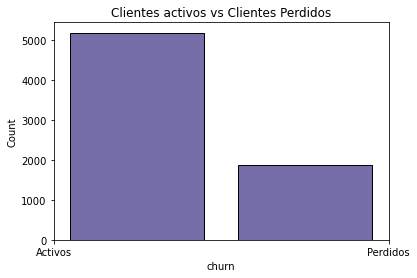

In [188]:
sns.histplot(data=df,x='churn', bins=2,shrink=.8,color='darkslateblue',stat='count')
plt.title('Clientes activos vs Clientes Perdidos')
plt.xticks([0,1],['Activos','Perdidos'])

Este grafico nos señala de manera visual la diferencia de los clientes retenidos a los que ya no se cuentan con el servicio

### Tipo de contrato
<a id='contrato'></a>

Text(0.5, 1.0, 'Distribución de tipos de contrato con respecto a la retención')

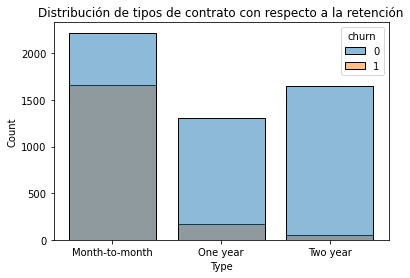

In [189]:
sns.histplot(data=df,x='Type', bins=2,shrink=.8,stat='count',hue='churn')
plt.title('Distribución de tipos de contrato con respecto a la retención')

* Aqui se puede observar que la mayoria de clientes que se va son los que estan mes a mes
es lo mas coherente ya que no tener contrato a plazo largo, se sienten con menos compromiso
* El quipo encargado del marketing tiene que diseñar algun tipo de campaña para que usuarios que estan de mes a mes, se comprometan a un contrato largo
* Seria interesante ver los tipos de planes que se ofrecen para ver si hay algo atractivo, porque muchas veces los tipos de contratos largos no se ajustan a la economia de los clientes o a algun servicio especifico

* Se puede apreciar que mas del 50% de los clientes se deciden contratar al mes por mes
* En caso contrario los contratos largos se reparten el porcentaje restante de los clientes
Es seguro que ese tipo de contratos tienen ventajas economicas e incluso puede ser de servicios adicionales
Sospecho que puede haber una correlación directa a si son usuarios de telefono o internet solamente
ya que es comun que en contratos largos se ofrescan servicios como el streaming


### Metodos de pago
<a id='metodos'></a>

Text(0.5, 1.0, 'Distribución de metodos de pago')

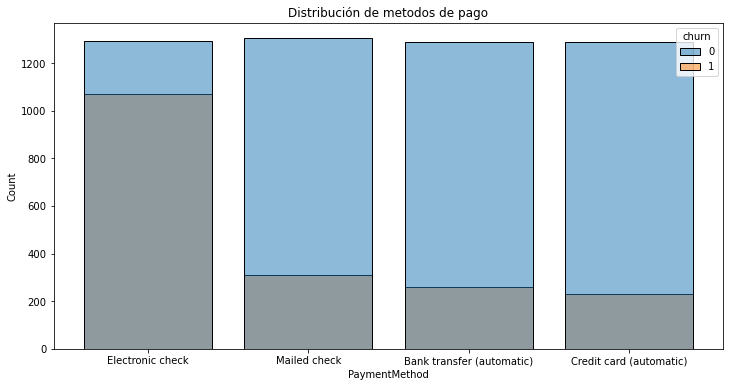

In [190]:
plt.figure(figsize=(12,6))
sns.histplot(data=df,x='PaymentMethod', bins=2,shrink=.8,stat='count',hue='churn')
plt.title('Distribución de metodos de pago')

El cheque electronico es el metodo de pago que mas se repite con un poco menos del 35%, el otro 65% se reparte de manera casi equitativa en los otros 3 metodos, siendo el cheque por correo un poco mas comun, no se si esto sirva para el analisis posterior.

Como era de esperarse el cheque electronico presenta a una menor cantidad de usuarios perdidos, por lo cual sospecho que abra una correlacion positiva con los que pagan mes a mes
en tanto a los otros metodos de pago el flujo de perdida de usuarios parece comportarse de manera constante


### Usuarios del servicio de internet
<a id='serviciosinternet'></a>

Text(0.5, 1.0, 'Distribución de servicios de internet')

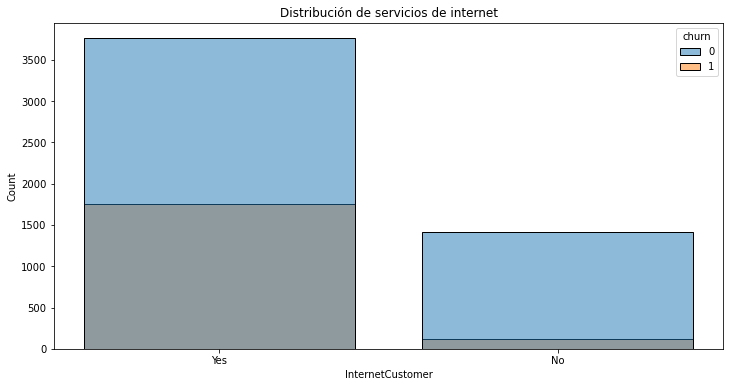

In [191]:
plt.figure(figsize=(12,6))
sns.histplot(data=df,x='InternetCustomer', bins=2,shrink=.8,stat='count',hue='churn')
plt.title('Distribución de servicios de internet')

In [192]:
df['InternetCustomer'].value_counts()

Yes    5517
No     1526
Name: InternetCustomer, dtype: int64

De 5517 cerca de 1750 usuarios son los que se retienen, es decir cerca del 31%
* Esta es señal de alarma porque posiblemente, se esten perdiendo clientes debido a un servicio de baja calidad en el internet, cabe señalar que esto incluye a los usuarios de banda ancha y a los usuarios de fibra optica

Por su parte un porcentaje minimo de los clientes que ya no cuentan con los servicios nunca tuvieron servicios de internet

En otro analisis sobre el tipo de conexión se observa una tendencia a una mayor cantidad de fuga de usuarios por la banda ancha, pero lo descarte por falta de información sobre todo la geografica y la que abarca las coberturas, y revisar si algun competidor ofrece ese servicio especificamente en esos lugares, ya que esto podria ser un indicativo de una migración para mejorar el performance de su conexión a internet, independientemente de los demás servicios

### Genero sexual
<a id='genero'></a>

Text(0.5, 1.0, 'Distribución de clientes por genero')

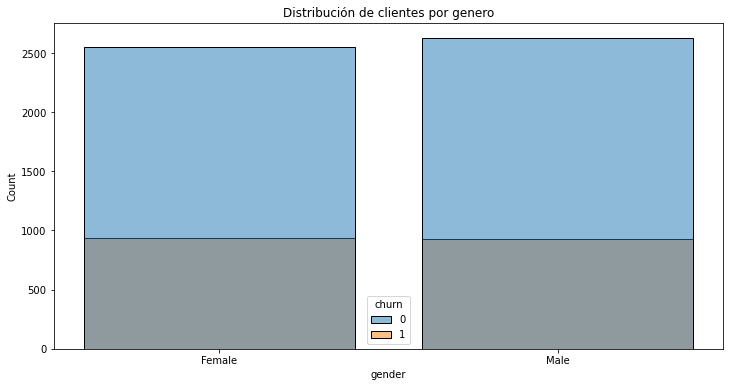

In [193]:
plt.figure(figsize=(12,6))
sns.histplot(data=df,x='gender', bins=2,shrink=.8,stat='count',hue='churn')
plt.title('Distribución de clientes por genero')

In [194]:
df['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [195]:
3555/len(df['gender'])

0.504756495811444

In [196]:
3488/len(df['gender'])

0.495243504188556

La poblacion masculina representa el 50.50% y la poblacion femenina el 49.50%
y los usuarios que se fugaron son similares en ambos casos, con esto se puede concluir que el genero no marca una diferencia sifnificativa.

### Tendencía de Cargos
<a id='cargos'></a>

In [197]:
df['MonthlyCharges']=df['MonthlyCharges'].astype('float64')

In [198]:
df['TotalCharges']=df['TotalCharges'].astype('float64')

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   dependents        7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   MultipleLines     7043 non-null   object 
 9   PhoneCustomer     7043 non-null   object 
 10  InternetCustomer  7043 non-null   object 
 11  streaming         7043 non-null   object 
 12  support           7043 non-null   object 
 13  churn             7043 non-null   int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 1.1+ MB


Primeramente, cambiamos los tipos de datos de las columnas referentes a cantidades a dinero a el tipo de dato flotante
y mostramos un info para corroborar que se halla aplicado dicho cambio

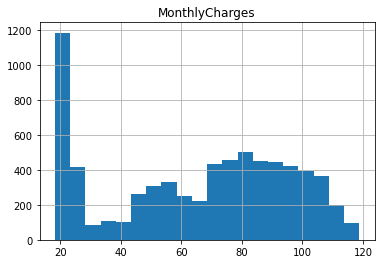

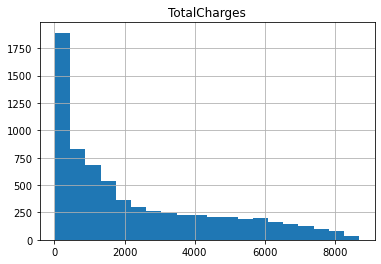

In [200]:
for feature in ['MonthlyCharges','TotalCharges']:
    df.hist(feature, bins=20);

Este grafico va de la mano a lo analizado anteriormente, referente a los tipos de contrato
la primera grafica indica claramente que la mayor cantidad de usuarios tiene un cargo mensual que ronda los 20 dolares, lo que es probable indique que tengan servicios basicos
En los cargos totales indican que la tendencia es menor, cabe señalar que esta incluye los usuarios fugados y los usuarios retenidos.

### Cargos Mensuales
<a id='mensuales'></a>


In [201]:
df.groupby('churn').size()

churn
0    5174
1    1869
dtype: int64

Primeramente sacamos el número de observaciones por grupo

Anteriormente se asumio que el comportamiento de la distribución de los usuarios fugados y los retenidos es la misma
Para corroborar esta hipotesis se realizaran una serie de pruebas
* primeramente del comportamiento
* ver graficamente el comportamiento
* por ultimo se realiza una prueba estadistica

In [202]:
monthly_charges_c=df.loc[df['churn']==1,'MonthlyCharges']

In [203]:
monthly_charges_d=df.loc[df['churn']==0,'MonthlyCharges']

In [204]:
mu_3, sigma_3 = stats.norm.fit(monthly_charges_c)

In [205]:
mu_4, sigma_4 = stats.norm.fit(monthly_charges_d)

In [206]:
x_3 =np.linspace(min(monthly_charges_c),max(monthly_charges_c),num=100)

In [207]:
x_4 =np.linspace(min(monthly_charges_d),max(monthly_charges_d),num=100)

In [208]:
y_3= stats.norm.pdf(x_3,mu_3,sigma_3)

In [209]:
y_4= stats.norm.pdf(x_4,mu_4,sigma_4)

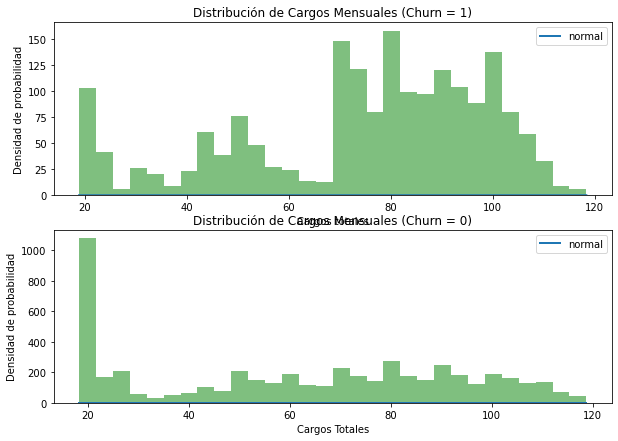

In [210]:
fig, axs = plt.subplots( 2, figsize=(10, 7))
axs[0].plot(x_3, y_3, linewidth=2, label='normal')
axs[0].hist(x=monthly_charges_c, bins=30, color="green", alpha=0.5)
axs[0].set_title('Distribución de Cargos Mensuales (Churn = 1)')
axs[0].set_xlabel('Cargos totales')
axs[0].set_ylabel('Densidad de probabilidad')
axs[0].legend()

axs[1].plot(x_4, y_4, linewidth=2, label='normal')
axs[1].hist(x=monthly_charges_d, bins=30, color="green", alpha=0.5)
axs[1].set_title('Distribución de Cargos Mensuales (Churn = 0)')
axs[1].set_xlabel('Cargos Totales')
axs[1].set_ylabel('Densidad de probabilidad')
axs[1].legend()



Las distribuciones de probabilidad a primera vista parecen no tener un comportamiento parecido

In [211]:
churn_cero = df[(df['churn']==0)]
churn_uno = df[(df['churn']==1)]

monthly_charges_f = churn_cero['MonthlyCharges']
monthly_charges_h = churn_uno['MonthlyCharges']

print('Kursotis de los usuarios fugados:', stats.kurtosis(monthly_charges_f))
print('Skewness de los usuarios fugados:', stats.skew(monthly_charges_f))
print('Kursotis de los usuarios retenidos:', stats.kurtosis(monthly_charges_h))
print('Skewness de los usuarios retenidos:', stats.skew(monthly_charges_h))

Kursotis de los usuarios fugados: -1.3551511690013145
Skewness de los usuarios fugados: -0.025012288702718842
Kursotis de los usuarios retenidos: -0.36375819567133183
Skewness de los usuarios retenidos: -0.7287883064780541


La prueba de kursotis nos señala que se tiene una evidente desviación de la normal, pero no extrema, la cual en ambos casos al ser negativa, arroja que es una distribución relativamente achatada, recordando que esta definición es con respecto a la distribucion normal
* En el caso de la prueba de skewness podemos observar que en ambos casos que es un valor negativo, lo cual indica que se tiene una cola asimetrica con tendencia a los valores negativos, en el primer grafico esto se puede visualizar de mejor manera

No tiene caso comparar las dos distribuciones porque no se comportar como una distribución normal, es decir no tienen simetria

In [212]:
retained = df.query('churn == 0')
lost = df.query('churn == 1')

In [213]:
retained.columns

Index(['gender', 'SeniorCitizen', 'dependents', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'MultipleLines',
       'PhoneCustomer', 'InternetCustomer', 'streaming', 'support', 'churn'],
      dtype='object')

In [214]:
retained['percent']=100*(retained['MonthlyCharges']/len(df['MonthlyCharges']))

C:\Users\omar_\AppData\Local\Temp/ipykernel_15484/1965935930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retained['percent']=100*(retained['MonthlyCharges']/len(df['MonthlyCharges']))


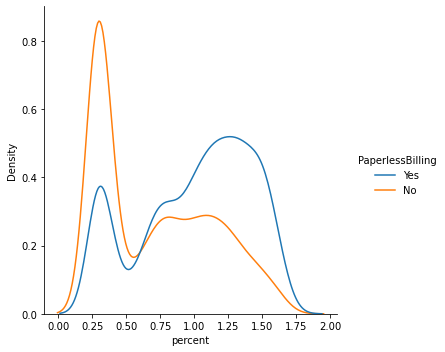

In [215]:
sns.displot(hue='PaperlessBilling',kind='kde', x = "percent", data = retained)

el gasto promedio de los que no usan papel  es mayor y la tendencia de los que si usan se concentra en menor promedio de gastos

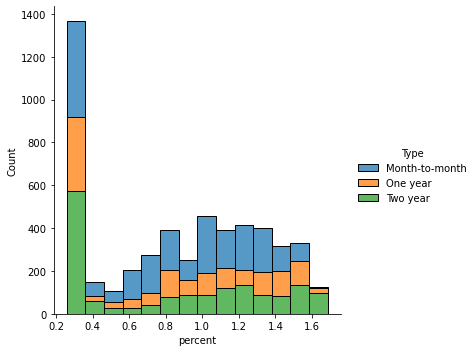

In [216]:
sns.displot(data=retained, x='percent', hue="Type", multiple="stack")

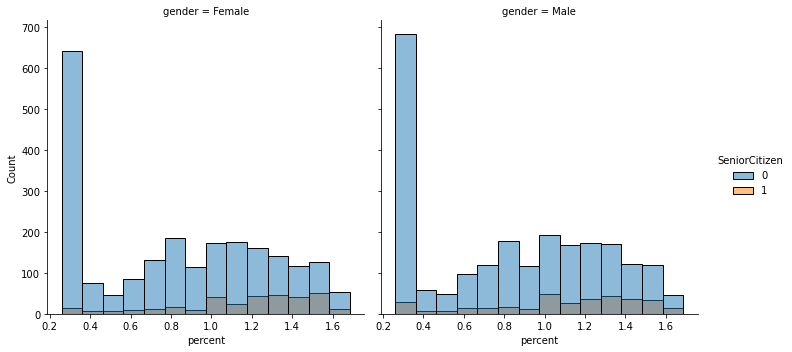

In [217]:
sns.displot(data=retained, x="percent", hue="SeniorCitizen", col="gender", kind="hist")

Con este grafico podemos ver que no hay distinciones por genero

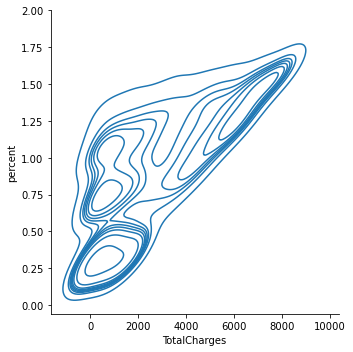

In [218]:
sns.displot(x = "TotalCharges", y = "percent", data = retained,kind='kde')

In [219]:
lost['percent']=100*(lost['MonthlyCharges']/len(df['MonthlyCharges']))

C:\Users\omar_\AppData\Local\Temp/ipykernel_15484/1910389167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lost['percent']=100*(lost['MonthlyCharges']/len(df['MonthlyCharges']))


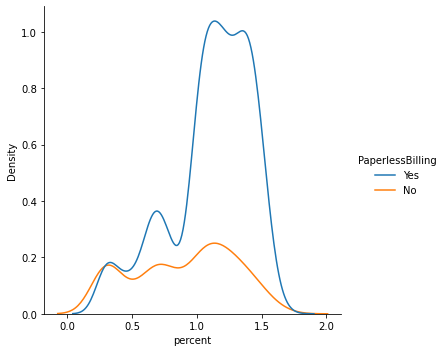

In [220]:
sns.displot(hue='PaperlessBilling',kind='kde', x = "percent", data = lost)

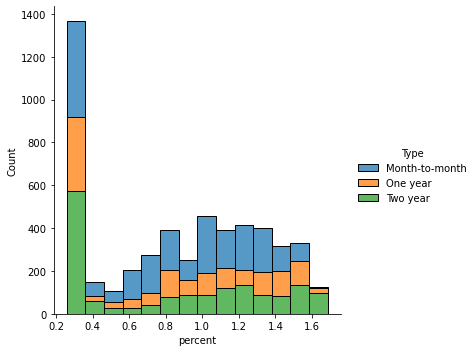

In [221]:
sns.displot(data=retained, x='percent', hue="Type", multiple="stack")

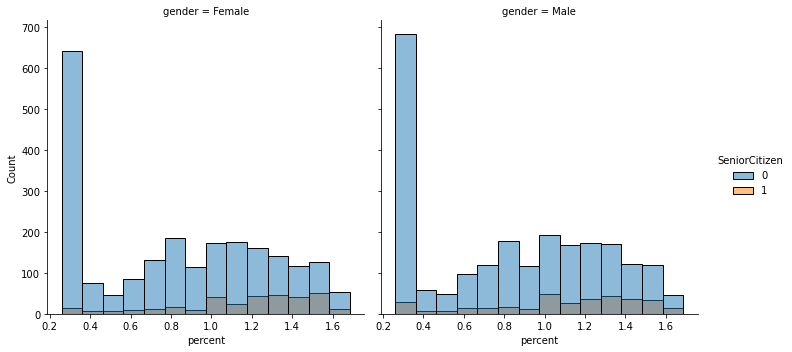

In [222]:
sns.displot(data=retained, x="percent", hue="SeniorCitizen", col="gender", kind="hist")

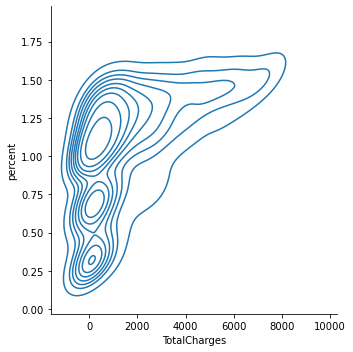

In [223]:
sns.displot(x = "TotalCharges", y = "percent", data = lost,kind='kde')

### Cargos totales
<a id='totales'></a>


In [224]:
df.groupby('churn').size()

churn
0    5174
1    1869
dtype: int64

Primeramente sacamos el número de observaciones por grupo

In [225]:
total_charges_c=df.loc[df['churn']==1,'TotalCharges']

In [226]:
total_charges_d=df.loc[df['churn']==0,'TotalCharges']

In [227]:
mu, sigma = stats.norm.fit(total_charges_c)

In [228]:
mu_2, sigma_2 = stats.norm.fit(total_charges_d)

In [229]:
x =np.linspace(min(total_charges_c),max(total_charges_c),num=100)

In [230]:
x_2 =np.linspace(min(total_charges_d),max(total_charges_d),num=100)

In [231]:
y= stats.norm.pdf(x,mu,sigma)

In [232]:
y_2= stats.norm.pdf(x_2,mu_2,sigma_2)

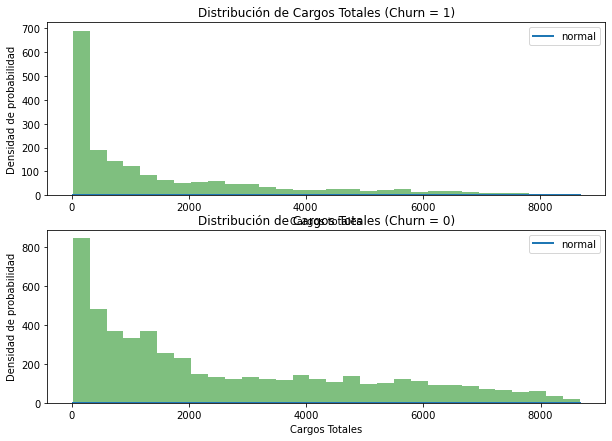

In [233]:
fig, axs = plt.subplots( 2, figsize=(10, 7))
axs[0].plot(x, y, linewidth=2, label='normal')
axs[0].hist(x=total_charges_c, bins=30, color="green", alpha=0.5)
axs[0].set_title('Distribución de Cargos Totales (Churn = 1)')
axs[0].set_xlabel('Cargos totales')
axs[0].set_ylabel('Densidad de probabilidad')
axs[0].legend()

axs[1].plot(x_2, y_2, linewidth=2, label='normal')
axs[1].hist(x=total_charges_d, bins=30, color="green", alpha=0.5)
axs[1].set_title('Distribución de Cargos Totales (Churn = 0)')
axs[1].set_xlabel('Cargos Totales')
axs[1].set_ylabel('Densidad de probabilidad')
axs[1].legend()



Las distribuciones de probabilidad a primera vista parecen tener un comportamiento parecido

In [234]:
churn_cero = df[(df['churn']==0)]
churn_uno = df[(df['churn']==1)]

In [235]:
total_charges_f = churn_cero['TotalCharges']
total_charges_h = churn_uno['TotalCharges']

In [236]:
print('Kursotis de clientes fugados:', stats.kurtosis(total_charges_f))
print('Skewness de clientes fugados:', stats.skew(total_charges_f))
print('Kursotis de clientes retenidos:', stats.kurtosis(total_charges_h))
print('Skewness de clientes retenidos:', stats.skew(total_charges_h))

Kursotis de clientes fugados: -0.5502850652333886
Skewness de clientes fugados: 0.8075892733422985
Kursotis de clientes retenidos: 1.4545874639846401
Skewness de clientes retenidos: 1.5097017123142646


La prueba de kursotis nos señala que se tiene una evidente desviación de la normal, pero no extrema, en el caso de los clientes fugados
* Pero la prueba skewness señala  nos indica que tiene una cola asimetrica hacia los valores positivos, en ambos casos lo cual se corrobora graficamente en un paso anterior
* En el caso de los clientes retenidos la prueba de kurtosis nos indica que es una grafica apuntada, lo cual podemos ver graficamente

No tiene caso comparar las dos distribuciones porque no se comportar como una distribución normal, es decir no tienen simetria

In [237]:
retained_t = df.query('churn == 0')
lost_t = df.query('churn == 1')

In [238]:
retained_t['percent']=100*(retained_t['MonthlyCharges']/len(df['MonthlyCharges']))

C:\Users\omar_\AppData\Local\Temp/ipykernel_15484/4162456332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retained_t['percent']=100*(retained_t['MonthlyCharges']/len(df['MonthlyCharges']))


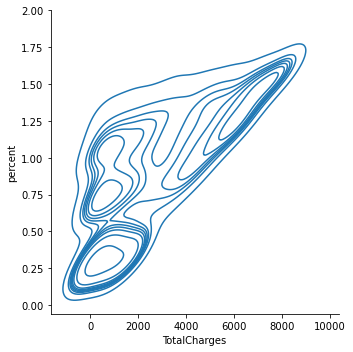

In [239]:
sns.displot(x = "TotalCharges", y = "percent", data = retained_t,kind='kde')

In [240]:
lost_t['percent']=100*(lost_t['MonthlyCharges']/len(df['MonthlyCharges']))

C:\Users\omar_\AppData\Local\Temp/ipykernel_15484/2875492683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lost_t['percent']=100*(lost_t['MonthlyCharges']/len(df['MonthlyCharges']))


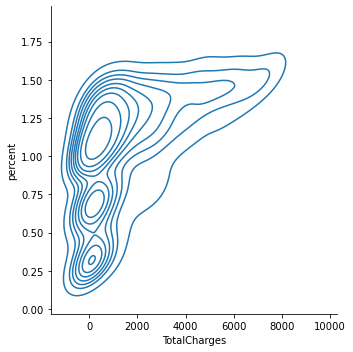

In [241]:
sns.displot(x = "TotalCharges", y = "percent", data = lost_t,kind='kde')

Las graficas anteriores representan las tendencias en promedio de los cargos mensuales, primero para los clientes fugados, y despues para los clientes retenidos.

## One Hot Encoding
<a id='ohe'></a>

El one hot ecoding es el proceso de convertir las variables categoricas al formato númerico
y asi tener un dataset en este caso de 1 y 0s

Lo primero es identificar las variables categoricas que tenemos para realizar el proceso

In [242]:
df.head()

,gender,SeniorCitizen,dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,PhoneCustomer,InternetCustomer,streaming,support,churn
0,Female,0,Yes,Month-to-month,Yes,Electronic check,29.85,29.850000,No,No,Yes,No,Yes,0
1,Male,0,No,One year,No,Mailed check,56.95,1889.500000,No,Yes,Yes,No,Yes,0
2,Male,0,No,Month-to-month,Yes,Mailed check,53.85,108.150002,No,Yes,Yes,No,Yes,1
3,Male,0,No,One year,No,Bank transfer (automatic),42.30,1840.750000,No,No,Yes,No,Yes,0
4,Female,0,No,Month-to-month,Yes,Electronic check,70.70,151.649994,No,Yes,Yes,No,No,1


In [243]:
columns_for_OHE = ['PaperlessBilling','gender','dependents', 'MultipleLines', 
                      'Type','PaymentMethod',
           'InternetCustomer', 'PhoneCustomer','streaming','support','SeniorCitizen','churn']
df = pd.get_dummies(df, drop_first=True, columns = columns_for_OHE)

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7043 non-null   float64
 1   TotalCharges                           7043 non-null   float64
 2   PaperlessBilling_Yes                   7043 non-null   uint8  
 3   gender_Male                            7043 non-null   uint8  
 4   dependents_Yes                         7043 non-null   uint8  
 5   MultipleLines_Yes                      7043 non-null   uint8  
 6   Type_One year                          7043 non-null   uint8  
 7   Type_Two year                          7043 non-null   uint8  
 8   PaymentMethod_Credit card (automatic)  7043 non-null   uint8  
 9   PaymentMethod_Electronic check         7043 non-null   uint8  
 10  PaymentMethod_Mailed check             7043 non-null   uint8  
 11  Inte

Con este proceso, pasamos de 13 caracterizticas a 16, es decir se generaron más columnas debido al metodo de pago  y una más por el tipo de contrato
* El siguiente paso es cambiar el nombre de estas empleando snake_case

## Snake_case
<a dir='snake'></a>

In [245]:
def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [246]:
df =  df.rename(columns = lambda x: to_snake_case(x))

In [247]:
df.columns

Index(['monthly_charges', 'total_charges', 'paperless_billing__yes',
       'gender__male', 'dependents__yes', 'multiple_lines__yes',
       'type__one year', 'type__two year',
       'payment_method__credit card (automatic)',
       'payment_method__electronic check', 'payment_method__mailed check',
       'internet_customer__yes', 'phone_customer__yes', 'streaming__yes',
       'support__yes', 'senior_citizen_1', 'churn_1'],
      dtype='object')

In [248]:
df.rename(columns = {'paperless_billing__yes':'paperless_billing', 'gender__male':'gender','dependents__yes':'dependents','multiple_lines__yes':'multiple_lines','type__one year':'one_year','type__two year':'two_year','payment_method__credit card (automatic)':'credit_card','payment_method__electronic check':'electronic_check','payment_method__mailed check':'mailed_check','internet_customer__yes':'internet_customer','phone_customer__yes':'phone_customer','streaming__yes':'streaming','support__yes':'support','senior_citizen_1':'senior_citizen','churn_1':'churn'}, inplace = True)

In [249]:
df.columns

Index(['monthly_charges', 'total_charges', 'paperless_billing', 'gender',
       'dependents', 'multiple_lines', 'one_year', 'two_year', 'credit_card',
       'electronic_check', 'mailed_check', 'internet_customer',
       'phone_customer', 'streaming', 'support', 'senior_citizen', 'churn'],
      dtype='object')

## Segmentación de datos
<a dir='segemntacion'></a>

Vamos a realizar dos matrices de las que ya teniamos, para tener 4
* Feature_valid
* Feature_train
* Target_valid
* Target_train

Con lo siguiente nos quedaran dos conjuntos (x,y) y (x2,y2), es decir un par para entrenar y otro para validar.
* se eligio una representación del 80% con el 20%, cuando el valor de la muestra de entrenamiento es mas pequeña, el resultado de las pruebas de error suele mejorar, pero una muestra tan pequeña no representa a el conjunto por lo cual puede ser engañoso
* Por otro lado se utiliza el parametro de random state para asegurar la aleatoriedad en la muestra

In [250]:
target = df['churn']
features = df.drop(['churn'], axis=1)

Separamos nuestro target, de las caracterizticas

In [251]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.20,random_state=12345)

## Balanceo de clases
<a dir='balanceo'></a>

Como se vio antes, la diferencia entre los fugados y retenidos es significativa, lo cual puede causar cierta confusión de los resultados cuando esta diferencia se incremente

Para poder llegar a un balance se disponen de diversar estrategia
* Ajuste de parametros
* Modificar el dataset
* Muestras artificiales
* Metodos de balance con ensamblamientos

El metodo escogido es un ensamble de metodos de balance, es decir se hara una combinacion de submuestreos con sobremuestres

*  Utilizando la funcion RandomUnderSampler hacemos un submuestreo, aplicando el balance en una proporcion de los datos
* RandomOverSampler se aplica sobre ese submuestreo


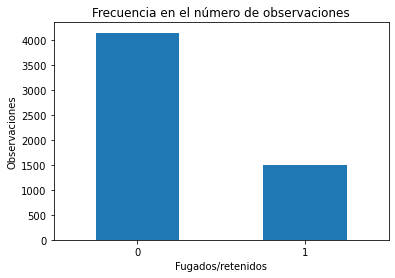

In [252]:
count_classes = pd.value_counts(target_train, sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title('Frecuencia en el número de observaciones')
plt.xlabel('Fugados/retenidos')
plt.ylabel("Observaciones");

In [253]:

features_train_unbalanced = features_train.copy()
target_train_unbalanced = target_train.copy()


rus = RandomUnderSampler(random_state=12345, sampling_strategy=0.50)
features_train, target_train = rus.fit_resample(features_train, target_train)


ros = RandomOverSampler(random_state=12345)
features_train_len = len(features_train)
features_train, target_train = ros.fit_resample(features_train, target_train)


Text(0.5, 0, 'Fugados/retenidos')

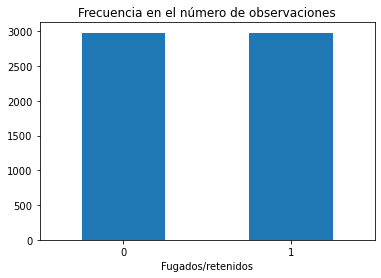

In [254]:
count_classes = pd.value_counts(target_train, sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title('Frecuencia en el número de observaciones')
plt.xlabel('Fugados/retenidos')
#plt.ylabel("Observaciones");

## Estandarizar datos
<a dir='estandarizar'></a>

Es importante estandarizar los valores que no son binarios, los cuales presentan un comportamiento continuo
* en este caso solo se presentan dos caracteristicas que se estandarizaran
    * monthly_charges y total_charges

* primero se mostraran los dos partes es decir la referente a la validacion y el entrenamiento
    * Con el objetivo de notar las diferencias

Por otro lado se opto por realizar este paso, a estas alturas del tratamiento de datos para evitar el posible dataleakage

In [255]:
features_valid.head()

,monthly_charges,total_charges,paperless_billing,gender,dependents,multiple_lines,one_year,two_year,credit_card,electronic_check,mailed_check,internet_customer,phone_customer,streaming,support,senior_citizen
1128,19.40,529.799988,1,1,0,0,0,0,0,1,0,0,1,0,0,0
2875,85.10,1873.699951,1,1,1,1,0,0,0,1,0,1,1,1,0,0
1783,71.65,71.650002,1,1,1,0,0,0,0,1,0,1,1,0,0,0
3804,79.85,797.250000,0,1,0,1,0,0,0,1,0,1,1,0,1,0
6087,39.95,1023.750000,1,1,1,0,1,0,0,0,0,1,0,1,1,0


In [256]:
features_train.head()

,monthly_charges,total_charges,paperless_billing,gender,dependents,multiple_lines,one_year,two_year,credit_card,electronic_check,mailed_check,internet_customer,phone_customer,streaming,support,senior_citizen
0,56.90,2560.100098,0,1,1,0,1,0,0,0,1,1,1,0,1,0
1,51.65,524.500000,1,1,0,0,0,0,0,0,1,1,1,0,1,0
2,95.90,6954.149902,1,0,1,1,0,1,0,0,0,1,1,1,1,0
3,45.20,45.200001,0,1,0,0,0,0,0,1,0,1,1,0,0,1
4,86.05,244.850006,1,1,0,0,0,0,0,0,1,1,1,1,1,0


In [257]:
numeric = [ 'monthly_charges','total_charges']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

C:\Users\omar_\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [258]:
features_valid.head()

,monthly_charges,total_charges,paperless_billing,gender,dependents,multiple_lines,one_year,two_year,credit_card,electronic_check,mailed_check,internet_customer,phone_customer,streaming,support,senior_citizen
1128,-1.667653,-0.694306,1,1,0,0,0,0,0,1,0,0,1,0,0,0
2875,0.600281,-0.078914,1,1,1,1,0,0,0,1,0,1,1,1,0,0
1783,0.135993,-0.904100,1,1,1,0,0,0,0,1,0,1,1,0,0,0
3804,0.419053,-0.571836,0,1,0,1,0,0,0,1,0,1,1,0,1,0
6087,-0.958277,-0.468119,1,1,1,0,1,0,0,0,0,1,0,1,1,0


In [259]:
features_train.head()

,monthly_charges,total_charges,paperless_billing,gender,dependents,multiple_lines,one_year,two_year,credit_card,electronic_check,mailed_check,internet_customer,phone_customer,streaming,support,senior_citizen
0,-0.373170,0.235399,0,1,1,0,1,0,0,0,1,1,1,0,1,0
1,-0.554398,-0.696733,1,1,0,0,0,0,0,0,1,1,1,0,1,0
2,0.973092,2.247501,1,0,1,1,0,1,0,0,0,1,1,1,1,0
3,-0.777049,-0.916211,0,1,0,0,0,0,0,1,0,1,1,0,0,1
4,0.633074,-0.824789,1,1,0,0,0,0,0,0,1,1,1,1,1,0


## Modelado
<a dir='modelado'></a>

### Entrenamiento de los modelos
<a dir='entrenamiento'></a>

Se crearan modelos para ver el mejor perfomance de estos
* Primero se creara una función que nos ayude a las graficas de las pruebas

In [260]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
        
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc
        
        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 
        
         # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        
        
        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return roc_auc

### Regresión logistica
<a dir='regresion'></a>

Regresión Logistica
          train  test
Accuracy   0.76  0.75
F1         0.76  0.62
APS        0.82  0.62
ROC AUC    0.83  0.83
ROC-AUC score: 0.8343161615902862


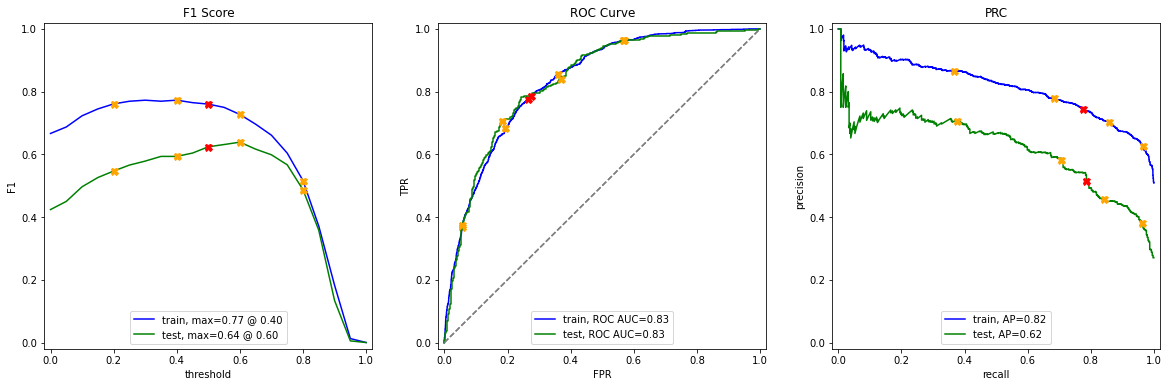

In [261]:
model = LogisticRegression(max_iter=20,
    random_state=12345, class_weight='balanced', solver='liblinear'
)
print('Regresión Logistica')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
roc_auc = evaluate_model(model, features_train, target_train, features_valid, target_valid)
print('ROC-AUC score:', roc_auc)


El resultado AUC-ROC sugiere que esto puede estar sobreajustado ligeramente.
Independientemente del performance, se probara con otros modelos.

### Arboles de decisión
<a dir='arboles'></a>

Arboles de decisión
          train  test
Accuracy   0.77  0.72
F1         0.78  0.61
APS        0.83  0.59
ROC AUC    0.85  0.82
ROC-AUC score: 0.8226925737121193


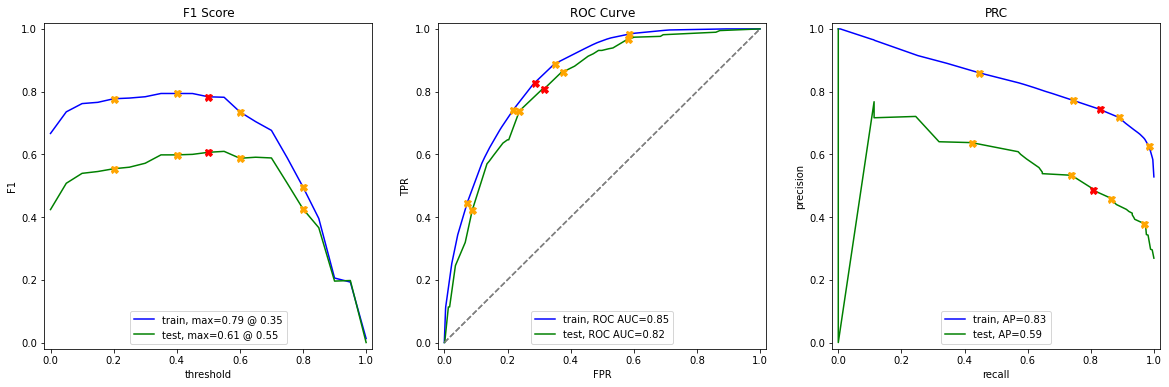

In [262]:
modeldt = DecisionTreeClassifier(random_state=12345, class_weight='balanced',criterion='entropy',max_depth=6,min_samples_split=10)
print('Arboles de decisión')
modeldt.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
roc_auc = evaluate_model(modeldt, features_train, target_train, features_valid, target_valid)
print('ROC-AUC score:', roc_auc)


De la misma manera que la regresión logistica, este tiende a ser sobreajustado, lo cual no es confiable.

### Random Forest
<a dir='random'></a>

Random Forest
          train  test
Accuracy    1.0  0.76
F1          1.0  0.59
APS         1.0  0.61
ROC AUC     1.0  0.81
ROC-AUC score: 0.8135153828419193


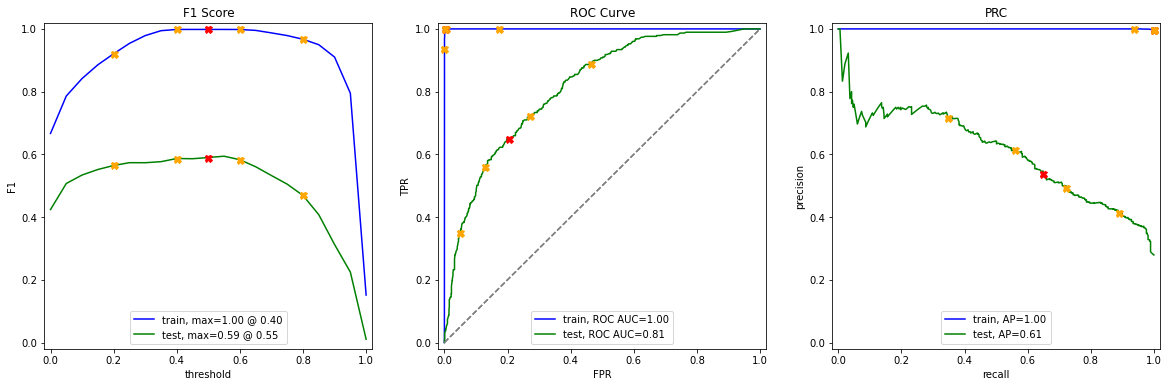

In [263]:
modelrf = RandomForestClassifier(criterion='entropy',random_state=12345,n_estimators=500,class_weight='balanced',
                                max_features='sqrt',)
print('Random Forest')
modelrf.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
roc_auc = evaluate_model(modelrf, features_train, target_train, features_valid, target_valid)
print('ROC-AUC score:', roc_auc)

La precision en los datos de entrenamiento es perfecta, entonces habria un sobreajuste a los datos de entrenamiento


### XGBClassifier
<a dir='xgbc'></a>

XGBClassifier
          train  test
Accuracy   0.95  0.76
F1         0.95  0.60
APS        0.99  0.62
ROC AUC    0.99  0.82
ROC-AUC score: 0.8158375387452929


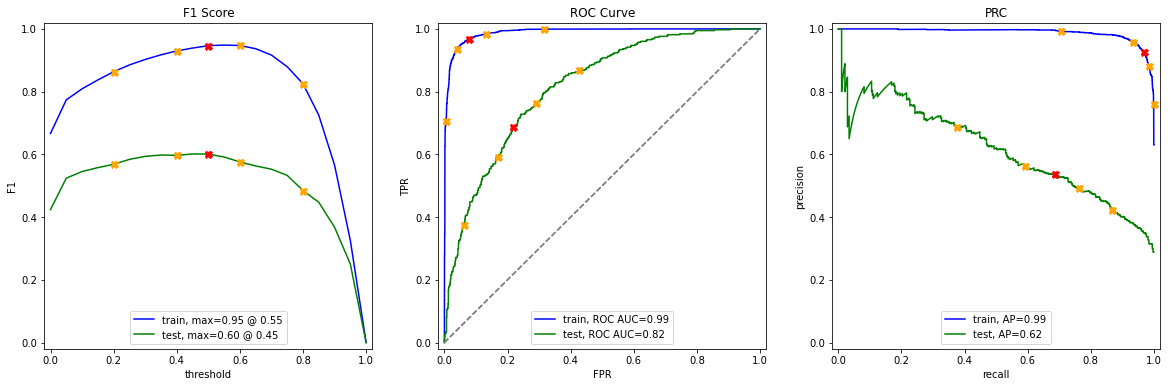

In [264]:
model_xgb = XGBClassifier(random_state=12345, colsample_bytree= 0.5,learning_rate=0.1,
                          max_depth=6, 
                          n_estimators=500, subsample=1)

print('XGBClassifier')
model_xgb.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
roc_auc = evaluate_model(model_xgb, features_train, target_train, features_valid, target_valid)
print('ROC-AUC score:', roc_auc)

Mismo caso que el modelo anterior

### LGBMClassifier
<a dir='lgbm'></a>

LGBMClassifier
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2980, number of negative: 2980
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 5960, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_

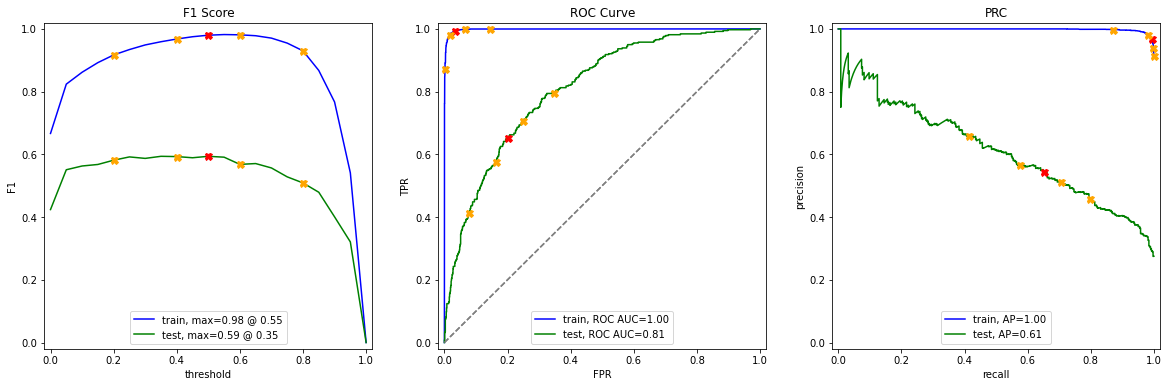

In [265]:
model_lgbm = LGBMClassifier(random_state=12345, colsample_bytree=1, learning_rate=0.1,
                            max_depth=20, n_estimators=500, subsample=0.5)
print('LGBMClassifier')
model_lgbm.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
roc_auc = evaluate_model(model_lgbm, features_train, target_train, features_valid, target_valid)
print('ROC-AUC score:', roc_auc)

## Validacion del mejor modelo
<a dir='mejor'></a>

* Todos los modelos tiene la metrica ROC-AUC por encima de 81
* Basandonos en eso la regresión logistica fue la que presento mejor indicador


Regresión Logistica
          train  test
Accuracy   0.76  0.75
F1         0.76  0.62
APS        0.82  0.62
ROC AUC    0.83  0.83
ROC-AUC score: 0.8343161615902862


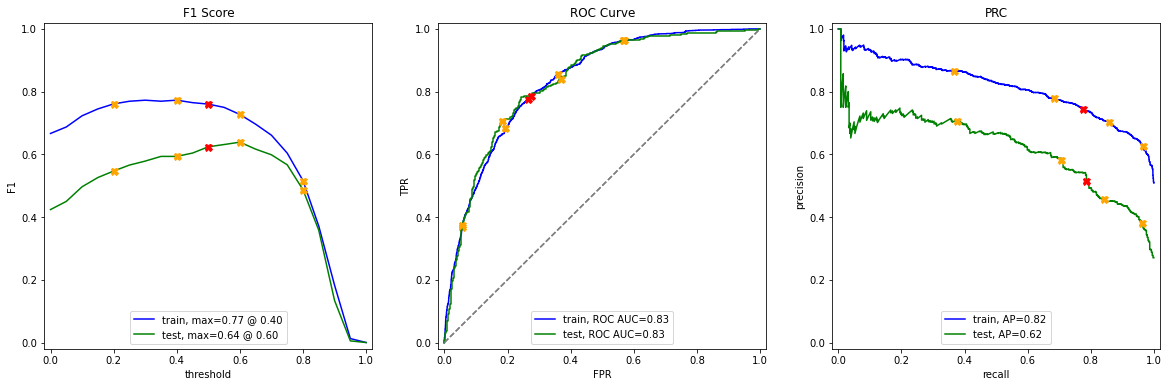

In [266]:
model = LogisticRegression(max_iter=20,
    random_state=12345, class_weight='balanced', solver='liblinear'
)
print('Regresión Logistica')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
roc_auc = evaluate_model(model, features_train, target_train, features_valid, target_valid)
print('ROC-AUC score:', roc_auc)


## Conclusiones
<a dir='conclusiones'></a>

* Los modelos tuvieron 81% en la metrica ROC-AUC
* EL modelo de regresion logistica con 20 iteraciones mostro un ROC-AUC del 84%
* EL RandomForest con un n_stimator de 500 mostro un ROC-AUC del 82%
en este caso se recomienda la regresion logistica

* En nuestro caso el mejor modelo recomendado es la regresión logistica, este modelo es el que nos arroja mejores resultados en la metrica de roc-auc
* Por otro lado se recomienda dar los resultados al equipo de marketing y hacer más atractivos ciertos productos, relacionados con las tendencias observadas valdria la pena, que la base de datos se enriquezca para tener unas predicciones mas acertadas en el analisis ya que se carece de información acerca de los servicios ofrecidos, de las coberturas e incluso de los precios de los servicios lo cual puede ser un factor oculto para predecir que el cliente tiende a fugarze.

